# LSGAN with MNIST (or Fashion MNIST)

* `Least Squares Generative Adversarial Networks`, [arXiv:1611.04076](https://arxiv.org/abs/1611.04076)
  * Xudong Mao, Qing Li, Haoran Xie, Raymond Y.K. Lau, Zhen Wang, and Stephen Paul Smolley
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
* based on DCGAN model

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'lsgan'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 256
learning_rate_D = 1e-4
learning_rate_G = 1e-3
k = 1 # the number of step of learning D before learning G (Not used in this code)
num_examples_to_generate = 25
noise_dim = 100

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)
# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Create the generator and discriminator models

In [5]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space.
    G(z): z -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = ConvTranspose(256, 3, padding='valid')
    self.conv2 = ConvTranspose(128, 3, padding='valid')
    self.conv3 = ConvTranspose(64, 4)
    self.conv4 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [1, 1, 100]
    conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
    conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
    generated_images = self.conv4(conv3, training=training) # generated_images: [28, 28, 1]
    
    return generated_images

In [6]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate real image x whether real or fake.
    D(x): x -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu')
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu')
    self.conv3 = Conv(256, 3, 2, padding='valid', activation='leaky_relu')
    self.conv4 = Conv(1, 3, 1, padding='valid', apply_batchnorm=False, activation='none')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [28, 28, 1]
    conv1 = self.conv1(inputs)                            # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1)                             # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2)                             # conv3: [3, 3, 256]
    conv4 = self.conv4(conv3)                             # conv4: [1, 1, 1]
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2]) # discriminator_logits: [1,]
    
    return discriminator_logits

In [7]:
generator = Generator()
discriminator = Discriminator()

### Plot generated image via generator network

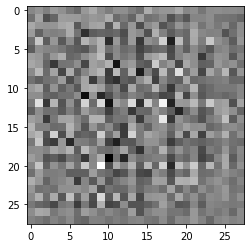

In [8]:
noise = tf.random.normal([1, 1, 1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Test discriminator network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilites

In [9]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.319826]], shape=(1, 1), dtype=float32)


## Define the loss functions and the optimizer

In [10]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)
mse = tf.losses.MeanSquaredError()

In [11]:
def GANLoss(logits, is_real=True, use_lsgan=True):
  """Computes standard GAN or LSGAN loss between `logits` and `labels`.

  Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.
    use_lsgan (`bool`): True means LSGAN loss, False means standard GAN loss.

  Returns:
    loss (`0-rank Tensor`): the standard GAN or LSGAN loss value. (binary_cross_entropy or mean_squared_error)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)
    
  if use_lsgan:
    loss = mse(labels, tf.nn.sigmoid(logits))
  else:
    loss = bce(labels, logits)
    
  return loss

In [12]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [13]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [14]:
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)

## Checkpoints (Object-based saving)

In [15]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [16]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
const_random_vector_for_saving = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                   minval=-1.0, maxval=1.0)

### Define training one step function

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_logits = discriminator(images, training=True)
    fake_logits = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_logits)
    disc_loss = discriminator_loss(real_logits, fake_logits)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return gen_loss, disc_loss

### Train full steps

In [18]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):

  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    gen_loss, disc_loss = train_step(images)
    global_step.assign_add(1)

    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      random_vector_for_sampling = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                     minval=-1.0, maxval=1.0)
      sample_images = generator(random_vector_for_sampling, training=False)
      print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = generator(const_random_vector_for_saving, training=False)
    print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                is_square=True, is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Training Done.')

Start Training.


KeyboardInterrupt: 

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = generator(const_random_vector_for_saving, training=False)
print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                            is_square=True, is_save=True, epoch=epoch+1,
                            checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

## Generate a GIF of all the saved images.

In [ ]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

In [ ]:
display.Image(filename=filename + '.png')